In [81]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

#WordCloud
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

#twitter api
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
   
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import warnings 
import json
import tweepy
import csv
import codecs
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

twitter_cred = dict()

twitter_cred['CONSUMER_KEY'] = '2eKSRZ4rCtvI0P530zEmjEeIE'
twitter_cred['CONSUMER_SECRET'] = 'OUVG2jcIjRRuVvJ053RRuwPyAKxt9QXGz7GeKh35V24RsfO5Ep'
twitter_cred['ACCESS_KEY'] = '1392379572-rAHYsSNQCfEmcQndKMBqtIsp018Tb95mz1E9Jyy'
twitter_cred['ACCESS_SECRET'] = 'esUTGAcsgNhHPcEE3qwQd2Y6yL1sun3baRx02YmrUy83z'

In [82]:
with open('twitter_credentials.json', 'w') as secret_info:
    json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)



In [83]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']


In [84]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manalisharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [85]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "utf-8"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

Dataset details

>target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

>ids: The id of the tweet ( 2087)

>date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

>flag: The query (lyx). If there is no query, then this value is NO_QUERY.

>user: the user that tweeted (robotickilldozr)

>text: the text of the tweet (Lyx is cool)

### Stream Listener for Twitter Sentiment Analysis

In [156]:

import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
  
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [157]:
df = pd.DataFrame(columns = ['Tweets', 'User', 'User_statuses_count', 
                             'user_followers', 'User_location', 'User_verified',
                             'fav_count', 'rt_count', 'tweet_date'])

In [158]:
def stream(data, file_name):
    i = 0
    for tweet in tweepy.Cursor(api.search, q=data, count=100, lang='en').items():
        print(i, end='\r')
        df.loc[i, 'Tweets'] = tweet.text
        df.loc[i, 'User'] = tweet.user.name
        df.loc[i, 'User_statuses_count'] = tweet.user.statuses_count
        df.loc[i, 'user_followers'] = tweet.user.followers_count
        df.loc[i, 'User_location'] = tweet.user.location
        df.loc[i, 'User_verified'] = tweet.user.verified
        df.loc[i, 'fav_count'] = tweet.favorite_count
        df.loc[i, 'rt_count'] = tweet.retweet_count
        df.loc[i, 'tweet_date'] = tweet.created_at
        df.to_excel('{}.xlsx'.format(file_name))
        i+=1
        if i == 1000:
            break
        else:
            pass

In [159]:
stream(data = ['AI'], file_name = 'tweets_sentiment')

In [160]:
df.head()

,Tweets,User,User_statuses_count,user_followers,User_location,User_verified,fav_count,rt_count,tweet_date
0,RT @Claire_Harris82: #Trading in action.\n\n#t...,Africantabs,17401,183,,False,0,12,2019-04-21 10:42:41
1,RT @amardeepkaushal: How To Use #MachineLearni...,amardeep kaushal,35748,3960,"Bengaluru,India.",False,0,10,2019-04-21 10:42:39
2,#NoCollusion #NoObstruction strike back at Dir...,Charles Ben Vance,4602,1271,Texas,False,0,0,2019-04-21 10:42:35
3,RT @hubermantamir: Demystifying AI and machine...,Santchi,212845,4805,Wirral,False,0,1,2019-04-21 10:42:32
4,RT @SASsoftware: The true potential of AI isn’...,Augus,800,1975,"Nairobi, Kenya.",False,0,153,2019-04-21 10:42:30


In [162]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
Tweets                 1000 non-null object
User                   1000 non-null object
User_statuses_count    1000 non-null object
user_followers         1000 non-null object
User_location          1000 non-null object
User_verified          1000 non-null object
fav_count              1000 non-null object
rt_count               1000 non-null object
tweet_date             1000 non-null object
dtypes: object(9)
memory usage: 118.1+ KB


In [209]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity ==0:
        return 'Neutral'
    else:
        return 'Negative'


    

In [210]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['Tweets'], "@[\w]*")
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df['Sentiment'] = df['clean_tweet'].apply(lambda x: analyze_sentiment(x))

In [211]:
#printing particular tweet
n=20
print('Original tweet:\n'+ df['Tweets'][n])
print('Clean tweet:\n'+df['clean_tweet'][n])
print('Sentiment:\n'+df['Sentiment'][n])

Original tweet:
Hot Off The Press: Elementor Introduces Related Posts, Date Filter &amp; Exclude Options https://t.co/SiTRKz1osS… https://t.co/Tt25Mbp0LQ
Clean tweet:
Press Elementor Introduces Related Posts Date Filter Exclude Options https SiTRKz https
Sentiment:
Neutral


In [212]:
df.head()

,Tweets,User,User_statuses_count,user_followers,User_location,User_verified,fav_count,rt_count,tweet_date,clean_tweet,Sentiment
0,RT @Claire_Harris82: #Trading in action.\n\n#t...,Africantabs,17401,183,,False,0,12,2019-04-21 10:42:41,#Trading action #trade #energy #commodity #mar...,Positive
1,RT @amardeepkaushal: How To Use #MachineLearni...,amardeep kaushal,35748,3960,"Bengaluru,India.",False,0,10,2019-04-21 10:42:39,#MachineLearning Build Predictive #Algorithm h...,Neutral
2,#NoCollusion #NoObstruction strike back at Dir...,Charles Ben Vance,4602,1271,Texas,False,0,0,2019-04-21 10:42:35,#NoCollusion #NoObstruction strike back Dirty ...,Negative
3,RT @hubermantamir: Demystifying AI and machine...,Santchi,212845,4805,Wirral,False,0,1,2019-04-21 10:42:32,Demystifying machine learning executives https...,Neutral
4,RT @SASsoftware: The true potential of AI isn’...,Augus,800,1975,"Nairobi, Kenya.",False,0,153,2019-04-21 10:42:30,true potential found line code plot movie real...,Positive


### Sentiment Distribution

In [213]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


In [214]:
df['Sentiment'].value_counts().iplot(kind='bar', xTitle='Sentiment',
                                    yTitle='Count', title='Overall Sentiment Distribution')

In [215]:
df_popular = df[df['rt_count'] >= 100]
df_popular['Sentiment'].value_counts().iplot(kind='bar', xTitle='Sentiment',
                                    yTitle='Count', title = 'Sentiment Distribution for <br> popular tweets (Above 100)')


In [216]:
df_unpopular = df[df['rt_count'] <= 100]
df_unpopular['Sentiment'].value_counts().iplot(kind='bar', xTitle='Sentiment',
                                    yTitle='Count', title = ('Sentiment Distribution for <br> unpopular tweets '))


In [217]:
#correlation between Tweeting Frequency and Followers
#Plot the number of statuses per user vs. number of followers per user.
#Differentiate between verified and non-verified users in our plot.

df.iplot(x='User_statuses_count', y = 'user_followers', mode='markers'
        , categories='User_verified',layout=dict(
        xaxis=dict(type='log', title='No. of Statuses'),
        yaxis=dict(type='log', title='No. of followers'),
        title='No. of statuses vs. No. of followers'))

### Tokenization
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [218]:
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [#Trading, action, #trade, #energy, #commodity...
1    [#MachineLearning, Build, Predictive, #Algorit...
2    [#NoCollusion, #NoObstruction, strike, back, D...
3    [Demystifying, machine, learning, executives, ...
4    [true, potential, found, line, code, plot, mov...
Name: clean_tweet, dtype: object

### Stemming
Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.



In [219]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [#trade, action, #trade, #energi, #commod, #ma...
1    [#machinelearn, build, predict, #algorithm, ht...
2    [#nocollus, #noobstruct, strike, back, dirti, ...
3    [demystifi, machin, learn, execut, http, uegug...
4    [true, potenti, found, line, code, plot, movi,...
Name: clean_tweet, dtype: object

In [220]:
#put tokens back together.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df_cleans['Tokenized_tweets']= tokenized_tweet

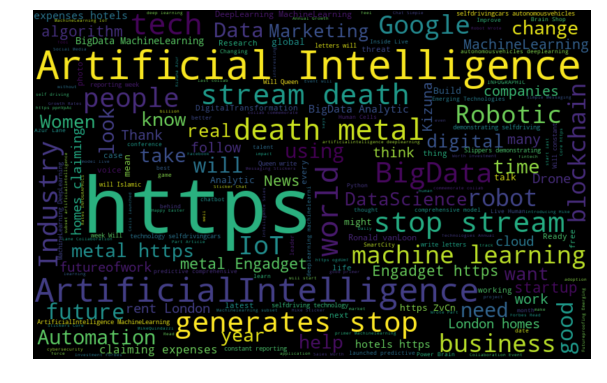

In [224]:
all_words = ' '.join([text for text in df['clean_tweet']])

wordcloud = WordCloud(width=800, height=500, stopwords=STOPWORDS,random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [227]:
df['sentiment_label'] = df['Sentiment'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

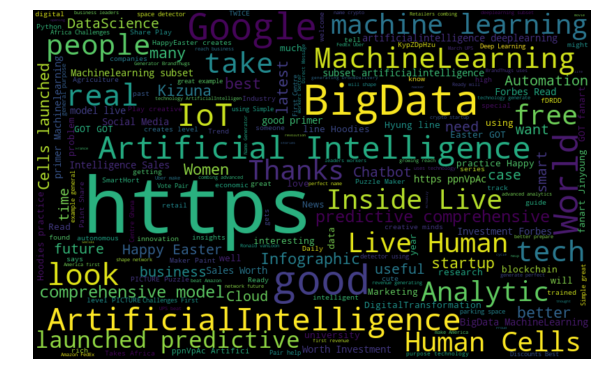

In [231]:
normal_words =' '.join([text for text in df['clean_tweet'][df['sentiment_label'] == 2]])

wordcloud = WordCloud(width=800, height=500, stopwords=STOPWORDS,random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')a
plt.show()

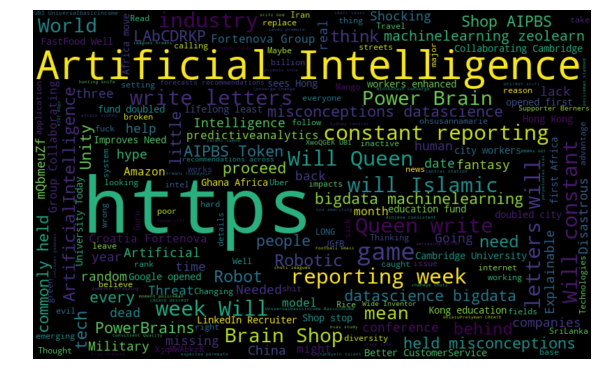

In [233]:
normal_words =' '.join([text for text in df['clean_tweet'][df['sentiment_label'] == 0]])

wordcloud = WordCloud(width=800, height=500, stopwords=STOPWORDS,random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()